# TM10007 Assignment template

In [ ]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [ ]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
#from worclipo.load_data import load_data
#from worcliver.load_data import load_data
#from ecg.load_data import load_data
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn as sns
import os

# Classifiers
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve

from sklearn.svm import SVR

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter 
from scipy.stats import shapiro
from scipy.signal import find_peaks
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc



def load_data():
    this_directory = os.getcwd()
    data = pd.read_csv(os.path.join(this_directory, 'Lipo_radiomicFeatures_with_nans.csv'), index_col=0)
    return data

data = load_data()

# Load the dataset
file_path = "data.csv"  # Ensure the dataset is in the same directory as the notebook
df = pd.read_csv(file_path)

# Display basic info and first few rows
df.info()
df.head()

## Preprocessing
### Missing values & Clean-up

In [ ]:
# Drop ID column as it is not useful for training
df.drop(columns=['ID'], inplace=True)

# Check for missing values and store them
missing_values = df[df.isna().any(axis=1)]

if not missing_values.empty:
    print(f"{missing_values.shape[0]} samples with missing values stored in missing_values")
    df = df.drop(missing_values.iloc[0:,:].index)
else:
    print("No missing values found")

# Encode the target variable
df['label'] = df['label'].map({'lipoma': 0, 'liposarcoma': 1})

# Display dataset after preprocessing
df.head()

## Data Description

In [ ]:
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Find ratio lipoma - liposarcoma
print(f"Sick-Healthy ratio: {df['label'].sum()}-{df.shape[0]-df['label'].sum()}") 

# Gaussian distributed featues in healthy data
df_label0 = df[df['label']==0]
not_normal_dist0 = 0
for column in df.columns[1:]:
    column_data = df_label0[column].values

    statistic, pvalue = shapiro(column_data)
    if float(pvalue) > 0.05:
        not_normal_dist0 += 1

# Gaussian distributed featues in sick data
df_label1 = df[df['label']==1]
not_normal_dist1 = 0
for column in df.columns[1:]:
    column_data = df_label1[column].values

    statistic, pvalue = shapiro(column_data)
    if float(pvalue) > 0.05:
        not_normal_dist1 += 1

# Gaussian distributed featues in all data
not_normal_dist = 0
for column in df.columns[1:]:
    column_data = df[column].values

    statistic, pvalue = shapiro(column_data)
    if float(pvalue) > 0.05:
        not_normal_dist += 1

print(f"Ratio of Gaussian/NonGaussian feature distribution in all data: {not_normal_dist} - {df.shape[1]-not_normal_dist-1}")
print(f"Ratio of Gaussian/NonGaussian feature distribution in healthy data: {not_normal_dist0} - {df_label0.shape[1]-not_normal_dist0}")
print(f"Ratio of Gaussian/NonGaussian feature distribution in sick data: {not_normal_dist1} - {df_label1.shape[1]-not_normal_dist1}")

### Data Split

In [ ]:
# Split into train and test
X = df
y = df.iloc[:, 0]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=49)
X_train.drop(columns=['label'], inplace=True)
X_test.drop(columns=['label'], inplace=True)
print(f'The number of features left: {(X_train.shape[1])}')
print(f'The number of samples in train data: {(X_train.shape[0])}')
print(f'The number of samples in test data: {(X_test.shape[0])}')


### Data distribution & Scaling

In [ ]:
# Check Datadistributions & Scaling
normal = 0
outliers = 0
scaler_count = {"standard": 0, "minmax": 0, "robust":0}
scalers = {}

for column in X_train.columns:
    column_data = X_train[column].values

    # Check for normal distribtuin
    statistic, pvalue = shapiro(column_data)
    not_normal_dist = 1 if float(pvalue) <= 0.05 else 0
    if float(pvalue) > 0.05:
        normal += 1
    
    # Check for outliers
    Q1 = np.percentile(column_data, 25)
    Q3 = np.percentile(column_data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count = np.sum((column_data < lower_bound) | (column_data > upper_bound))
    if outliers_count > 0:
        outliers += 1
    
    # Choose appropriate scaler for each feature
    if not_normal_dist == 0:
        scalers[column] = StandardScaler()  
        scaler_count["standard"] += 1
    elif not_normal_dist != 0 and outliers_count == 0:
        scalers[column] = MinMaxScaler()  
        scaler_count["minmax"] += 1
    else:
        scalers[column] = RobustScaler()  
        scaler_count["robust"] += 1

scaled_data = pd.DataFrame()
for column in X_train.columns:
    column_data = X_train[column].values.reshape(-1,1)
    scalers[column].fit(column_data)
    scaled_column = scalers[column].transform(column_data)
    scaled_data[column] = scaled_column.flatten()
    
X_train = scaled_data
print(f"Standard scaler:{scaler_count["standard"]} -- MinMax scaler:{scaler_count["minmax"]} -- Robust scaler:{scaler_count["robust"]}")
print(f"Ratio of Gaussian/NonGaussian distributions in all data: {normal} - {X_train.shape[1]-normal}")
print(f"Ratio of NoOutliers/Outliers in features in all data: {X_train.shape[1]-outliers} - {outliers}")
print(scalers)

# Data scaling for test set without fitting again
scaled_test_data = pd.DataFrame()
for column in X_test.columns:
    column_data = X_test[column].values.reshape(-1,1)
    scaled_column = scalers[column].transform(column_data)
    scaled_test_data[column] = scaled_column.flatten()
X_test = scaled_test_data

# # Data scaling for missing_values set without fitting again moet pas later ofzo
# missing_values_data = pd.DataFrame()
# if missing_values.empty:
#     for column in missing_values.columns:
#         column_data = missing_values[column].values.reshape(-1,1)
#         scaled_column = scalers[column].transform(column_data)
#         missing_values_data[column] = scaled_column.flatten
# missing_values = missing_values


### Feature Selection
#### Variance

In [ ]:
# Feature selection based on variance
variance_selector = VarianceThreshold(threshold=0.01)
data_var= variance_selector.fit_transform(X_train.iloc[:, 1:])

print(f"Features reduced from {X_train.shape[1]} to {data_var.shape[1]} features after variation filtering")

In [ ]:
# # Apply PCA based on them to explain 99% of the data
# pca = decomposition.PCA(n_components= 0.9999999999999999)
# data_pca = pca.fit_transform(data_var)

# print(f'The number of columns after variance selection: {(data_pca.shape[1])}')
# print(f'The number of rows after variance selection: {(data_pca.shape[0])}')

#### Correlation 


In [ ]:
# Removing redundant features based on correlation
data_var_df = pd.DataFrame(data_var)
corr_matrix = data_var_df.corr().abs()  # Get absolute correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop features with correlation higher than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
data_cor = data_var_df.drop(columns=to_drop)

print(f"Features reduced from {data_var.shape[1]} to {data_cor.shape[1]} features after correlation filtering")


#### RFE: linear

/Applications/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

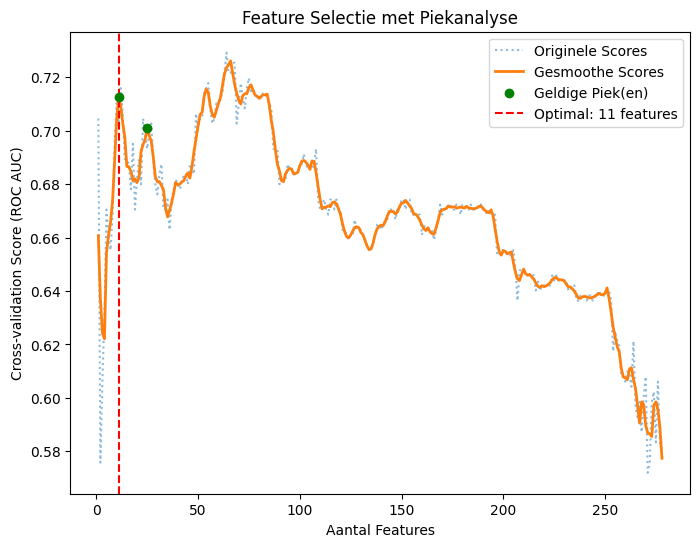

Optimale aantal features voor lineaire classifier: 11


In [46]:
# Linear feature selection by RFE
est_lin = LogisticRegression(max_iter=500)

# classifications
rfecv = feature_selection.RFECV(
    estimator = est_lin, step=1,
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
rfecv.fit(data_cor, y_train)

# Haal de CV-scores op
cv_scores = rfecv.cv_results_["mean_test_score"]
num_features = np.arange(1, len(cv_scores) + 1)

# Smooth de scores met Savitzky-Golay
smoothed_scores = savgol_filter(cv_scores, window_length=7, polyorder=2)  # Pas window_length aan als nodig

# Zoek pieken in de gesmoothe curve
peaks, properties = find_peaks(smoothed_scores, height=None)  # Zoekt alle pieken

# Voorwaarden
max_score = np.max(smoothed_scores)
threshold = max_score * 0.95  # 95% van de maximale score
feat_min = 5
feat_max = 30

# Filter pieken die:
# 1. Minimaal 5 features hebben (feat_min)
# 2. Maximaal 25 features hebben (feat_max)
# 3. Binnen de 5% marge van de max-score zitten (threshold)
valid_peaks = [p for p in peaks if feat_max >= num_features[p] >= feat_min and smoothed_scores[p] >= threshold]

# Selecteer de eerste geschikte piek, anders pakt hij de hoogste waarde
if valid_peaks:
    first_peak = valid_peaks[0]
    optimal_index = first_peak

    for next_peak in valid_peaks[1:]:
        if first_peak < next_peak <= first_peak + 3:
            if smoothed_scores[next_peak] > smoothed_scores[optimal_index]:
                optimal_index = next_peak
else:
    valid_indices = np.where((num_features >= 5) & (num_features <= 25))[0]
    optimal_index = valid_indices[np.argmax(smoothed_scores[valid_indices])]
optimal_features_lin = num_features[optimal_index]

# Plot de originele en gesmoothe scores
plt.figure(figsize=(8, 6))
plt.plot(num_features, cv_scores, label="Originele Scores", alpha=0.5, linestyle="dotted")
plt.plot(num_features, smoothed_scores, label="Gesmoothe Scores", linewidth=2)
plt.scatter(num_features[valid_peaks], smoothed_scores[valid_peaks], color='g', label="Geldige Piek(en)", zorder=3)
plt.axvline(optimal_features_lin, color='r', linestyle="--", label=f"Optimal: {optimal_features_lin} features")
plt.xlabel("Aantal Features")
plt.ylabel("Cross-validation Score (ROC AUC)")
plt.legend()
plt.title("Feature Selectie met Piekanalyse")
plt.show()

print(f"Optimale aantal features voor lineaire classifier: {optimal_features_lin}")


#### RFE: non-linear


/Applications/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature nam

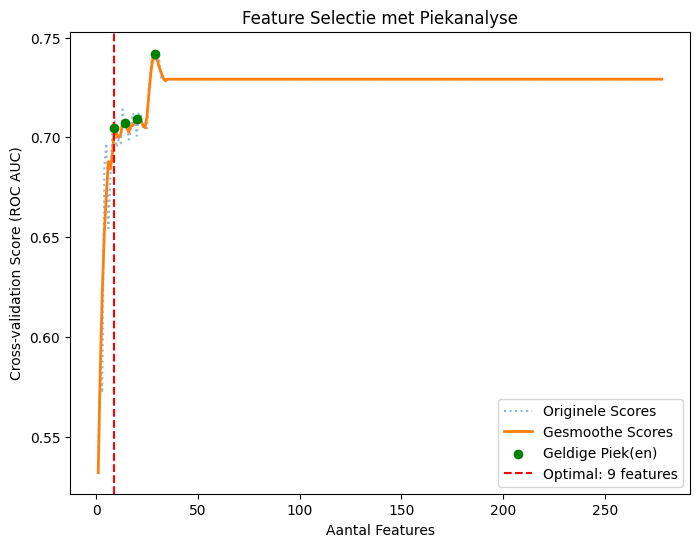

Optimale aantal features voor non-lineare classifier: 9


In [47]:
# Feature selection by RFE
est_nl = LGBMClassifier(n_estimators=50, learning_rate=0.1, random_state=42, verbose=-1)

# classifications
rfecv = feature_selection.RFECV(
    estimator = est_nl, step=1,
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
rfecv.fit(data_cor, y_train)

# Haal de CV-scores op
cv_scores = rfecv.cv_results_["mean_test_score"]
num_features = np.arange(1, len(cv_scores) + 1)

# Smooth de scores met Savitzky-Golay
smoothed_scores = savgol_filter(cv_scores, window_length=7, polyorder=2)  # Pas window_length aan als nodig

# Zoek pieken in de gesmoothe curve
peaks, properties = find_peaks(smoothed_scores, height=None)  # Zoekt alle pieken

# Voorwaarden
max_score = np.max(smoothed_scores)
threshold = max_score * 0.95  # 95% van de maximale score

# Filter pieken die:
# 1. Minimaal 5 features hebben (feat_min)
# 2. Maximaal 25 features hebben (feat_max)
# 3. Binnen de 5% marge van de max-score zitten (threshold)
valid_peaks = [p for p in peaks if feat_max >= num_features[p] >= feat_min and smoothed_scores[p] >= threshold]

# Selecteer de eerste geschikte piek, anders pakt hij de hoogste waarde
if valid_peaks:
    first_peak = valid_peaks[0]
    optimal_index = first_peak

    for next_peak in valid_peaks[1:]:
        if first_peak < next_peak <= first_peak + 3:
            if smoothed_scores[next_peak] > smoothed_scores[optimal_index]:
                optimal_index = next_peak
else:
    valid_indices = np.where((num_features >= 5) & (num_features <= 25))[0]
    optimal_index = valid_indices[np.argmax(smoothed_scores[valid_indices])]
optimal_features_nl = num_features[optimal_index]

# Plot de originele en gesmoothe scores
plt.figure(figsize=(8, 6))
plt.plot(num_features, cv_scores, label="Originele Scores", alpha=0.5, linestyle="dotted")
plt.plot(num_features, smoothed_scores, label="Gesmoothe Scores", linewidth=2)
plt.scatter(num_features[valid_peaks], smoothed_scores[valid_peaks], color='g', label="Geldige Piek(en)", zorder=3)
plt.axvline(optimal_features_nl, color='r', linestyle="--", label=f"Optimal: {optimal_features_nl} features")
plt.xlabel("Aantal Features")
plt.ylabel("Cross-validation Score (ROC AUC)")
plt.legend()
plt.title("Feature Selectie met Piekanalyse")
plt.show()

print(f"Optimale aantal features voor non-lineare classifier: {optimal_features_nl}")

#### Final feature selections
As the non-linear ROC AUC does not make much sense, we choose to go forward with only the linear features.

In [48]:
# Linear feature selection with Logistic Regression
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

feature_importance = np.abs(logreg.coef_[0])

n_importance = optimal_features_lin
important_features_lin = sorted(range(len(feature_importance)), key=lambda i: feature_importance[i], reverse=True)[:n_importance]
features = X_train.columns[important_features_lin]

print(f"Most important features (indices), linear: {features}")
print(f"Feature importances (coefficients): {feature_importance[important_features_lin]}")

# Filtering in datasets
X_train = X_train[features]
X_test = X_test[features]
print(features)

Most important features (indices), linear: Index(['PREDICT_original_vf_Frangi_inner_mean_SR(1.0, 10.0)_SS2.0',
       'PREDICT_original_vf_Frangi_inner_kurtosis_SR(1.0, 10.0)_SS2.0',
       'PREDICT_original_tf_LBP_energy_R3_P12',
       'PREDICT_original_vf_Frangi_full_quartile_range_SR(1.0, 10.0)_SS2.0',
       'PREDICT_original_vf_Frangi_edge_quartile_range_SR(1.0, 10.0)_SS2.0',
       'PREDICT_original_vf_Frangi_inner_std_SR(1.0, 10.0)_SS2.0',
       'PREDICT_original_tf_LBP_peak_position_R3_P12',
       'PREDICT_original_tf_Gabor_peak_F0.05_A0.0',
       'PREDICT_original_tf_Gabor_energy_F0.2_A0.79',
       'PREDICT_original_logf_energy_sigma1',
       'PREDICT_original_tf_Gabor_median_F0.05_A0.0'],
      dtype='object')
Feature importances (coefficients): [0.10637852 0.07239738 0.04912332 0.03233908 0.03233908 0.02159733
 0.02081453 0.01627649 0.01594914 0.01489112 0.01389816]
Index(['PREDICT_original_vf_Frangi_inner_mean_SR(1.0, 10.0)_SS2.0',
       'PREDICT_original_vf_Frangi_i

/Applications/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Return samples with missing values if possible

In [49]:
# Check for missing values in test data
missing_values.dropna(subset=features, inplace=True)

# Now we only keep the important features 
y_missing = missing_values['label'].map({'lipoma': 0, 'liposarcoma': 1})
missing_values.drop(columns=['label'], inplace=True)
X_missing = missing_values[features]

# And add it to the rest of the test data
X_test = pd.concat([X_test, X_missing], axis=0)
y_test = pd.concat([y_test, y_missing], axis=0)


/var/folders/7c/k7s45g950s74y_jl8zgdy5hh0000gn/T/ipykernel_7049/193519558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_values.dropna(subset=features, inplace=True)
/var/folders/7c/k7s45g950s74y_jl8zgdy5hh0000gn/T/ipykernel_7049/193519558.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_values.drop(columns=['label'], inplace=True)


#### Classifiers

/Applications/miniconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help redu

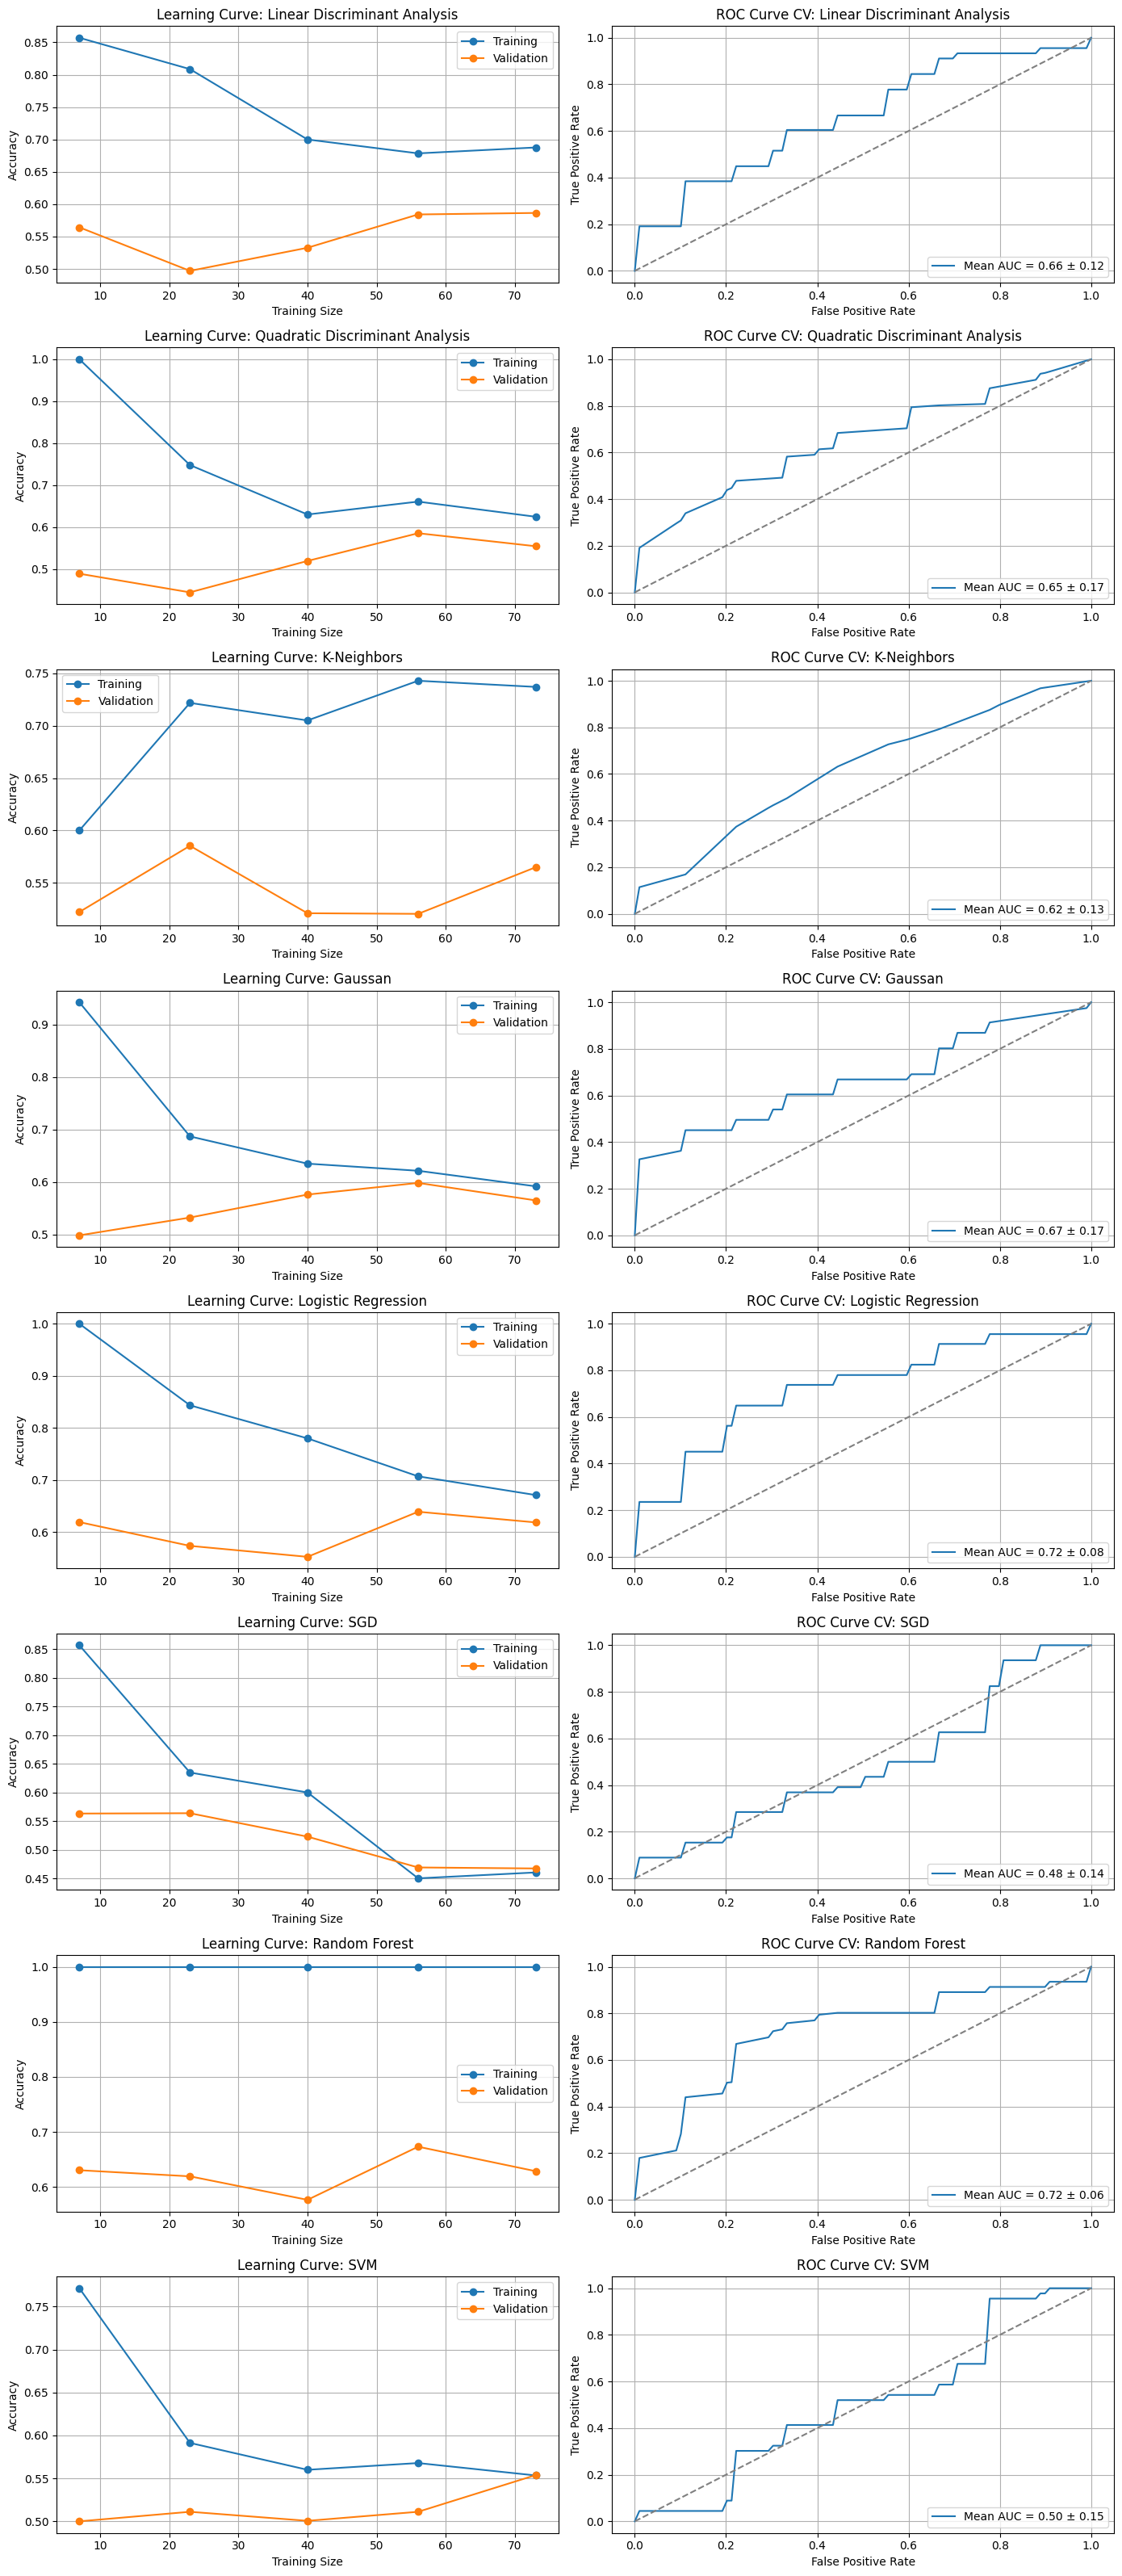

In [50]:
# Combination of classifiers
# Classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm 
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import roc_curve, auc

clsfs = [LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),KNeighborsClassifier(),GaussianNB(),
         LogisticRegression(),SGDClassifier(),RandomForestClassifier(),svm.SVC()]
clf_names = ["Linear Discriminant Analysis", "Quadratic Discriminant Analysis", "K-Neighbors", "Gaussan", 
               "Logistic Regression", "SGD", "Random Forest", "SVM"]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc_scores = {}

# For plotting
fig, axes = plt.subplots(len(clsfs), 2, figsize=(14, 4 * len(clsfs)))

# Loop through classifiers
for i, (clf, name) in enumerate(zip(clsfs, clf_names)):

    # --- 1. Learning Curve ---
    train_sizes, train_scores, val_scores = learning_curve(
        clf, X_train, y_train, cv=cv, scoring="accuracy",
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    axes[i, 0].plot(train_sizes, train_mean, 'o-', label="Training")
    axes[i, 0].plot(train_sizes, val_mean, 'o-', label="Validation")
    axes[i, 0].set_title(f"Learning Curve: {name}")
    axes[i, 0].set_xlabel("Training Size")
    axes[i, 0].set_ylabel("Accuracy")
    axes[i, 0].legend()
    axes[i, 0].grid()

    # --- 2. ROC AUC via Cross-Validation ---
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []

    for train_idx, test_idx in cv.split(X_train, y_train):
        clf.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        if hasattr(clf, "predict_proba"):
            probas = clf.predict_proba(X_train.iloc[test_idx])[:, 1]
        elif hasattr(clf, "decision_function"):
            probas = clf.decision_function(X_train.iloc[test_idx])
        else:
            continue  # Skip classifiers without either

        fpr, tpr, _ = roc_curve(y_train.iloc[test_idx], probas)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    cv_auc_scores[name] = mean_auc

    axes[i, 1].plot(mean_fpr, mean_tpr, label=f"Mean AUC = {mean_auc:.2f} ± {std_auc:.2f}")
    axes[i, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axes[i, 1].set_title(f"ROC Curve CV: {name}")
    axes[i, 1].set_xlabel("False Positive Rate")
    axes[i, 1].set_ylabel("True Positive Rate")
    axes[i, 1].legend(loc="lower right")
    axes[i, 1].grid()

plt.tight_layout()
plt.show()

In [51]:
# Classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm 

clsfs = [LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),KNeighborsClassifier(),GaussianNB(),
         LogisticRegression(),SGDClassifier(),RandomForestClassifier(),svm.SVC()]

Xs = [X_train]
Ys = [y_train]
num=0
clfs_fit = []

for clf in clsfs:
    for X, Y in zip(Xs, Ys):
        # Fit classifier
        clf.fit(X,Y)
        
        # # Predict labels using fitted classifier on training set
        # y_pred=clf.predict(X)
        # t=("Classifier: %s - Misclass: %d / %d" % (clf.__class__.__name__, (Y!=y_pred).sum(), X.shape[0]))

        # Predict labels using fitted classifier on test set
        y_pred = clf.predict(X_test)
        t = ("Misclassified: %d / %d" % ((y_test != y_pred).sum(), y_test.shape[0]))

        print(t)
        num+=1

        clfs_fit.append(clf)



Misclassified: 9 / 23
Misclassified: 9 / 23
Misclassified: 12 / 23
Misclassified: 9 / 23
Misclassified: 8 / 23
Misclassified: 11 / 23
Misclassified: 9 / 23
Misclassified: 12 / 23


/Applications/miniconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

#### ROC Curve

/Applications/miniconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help redu

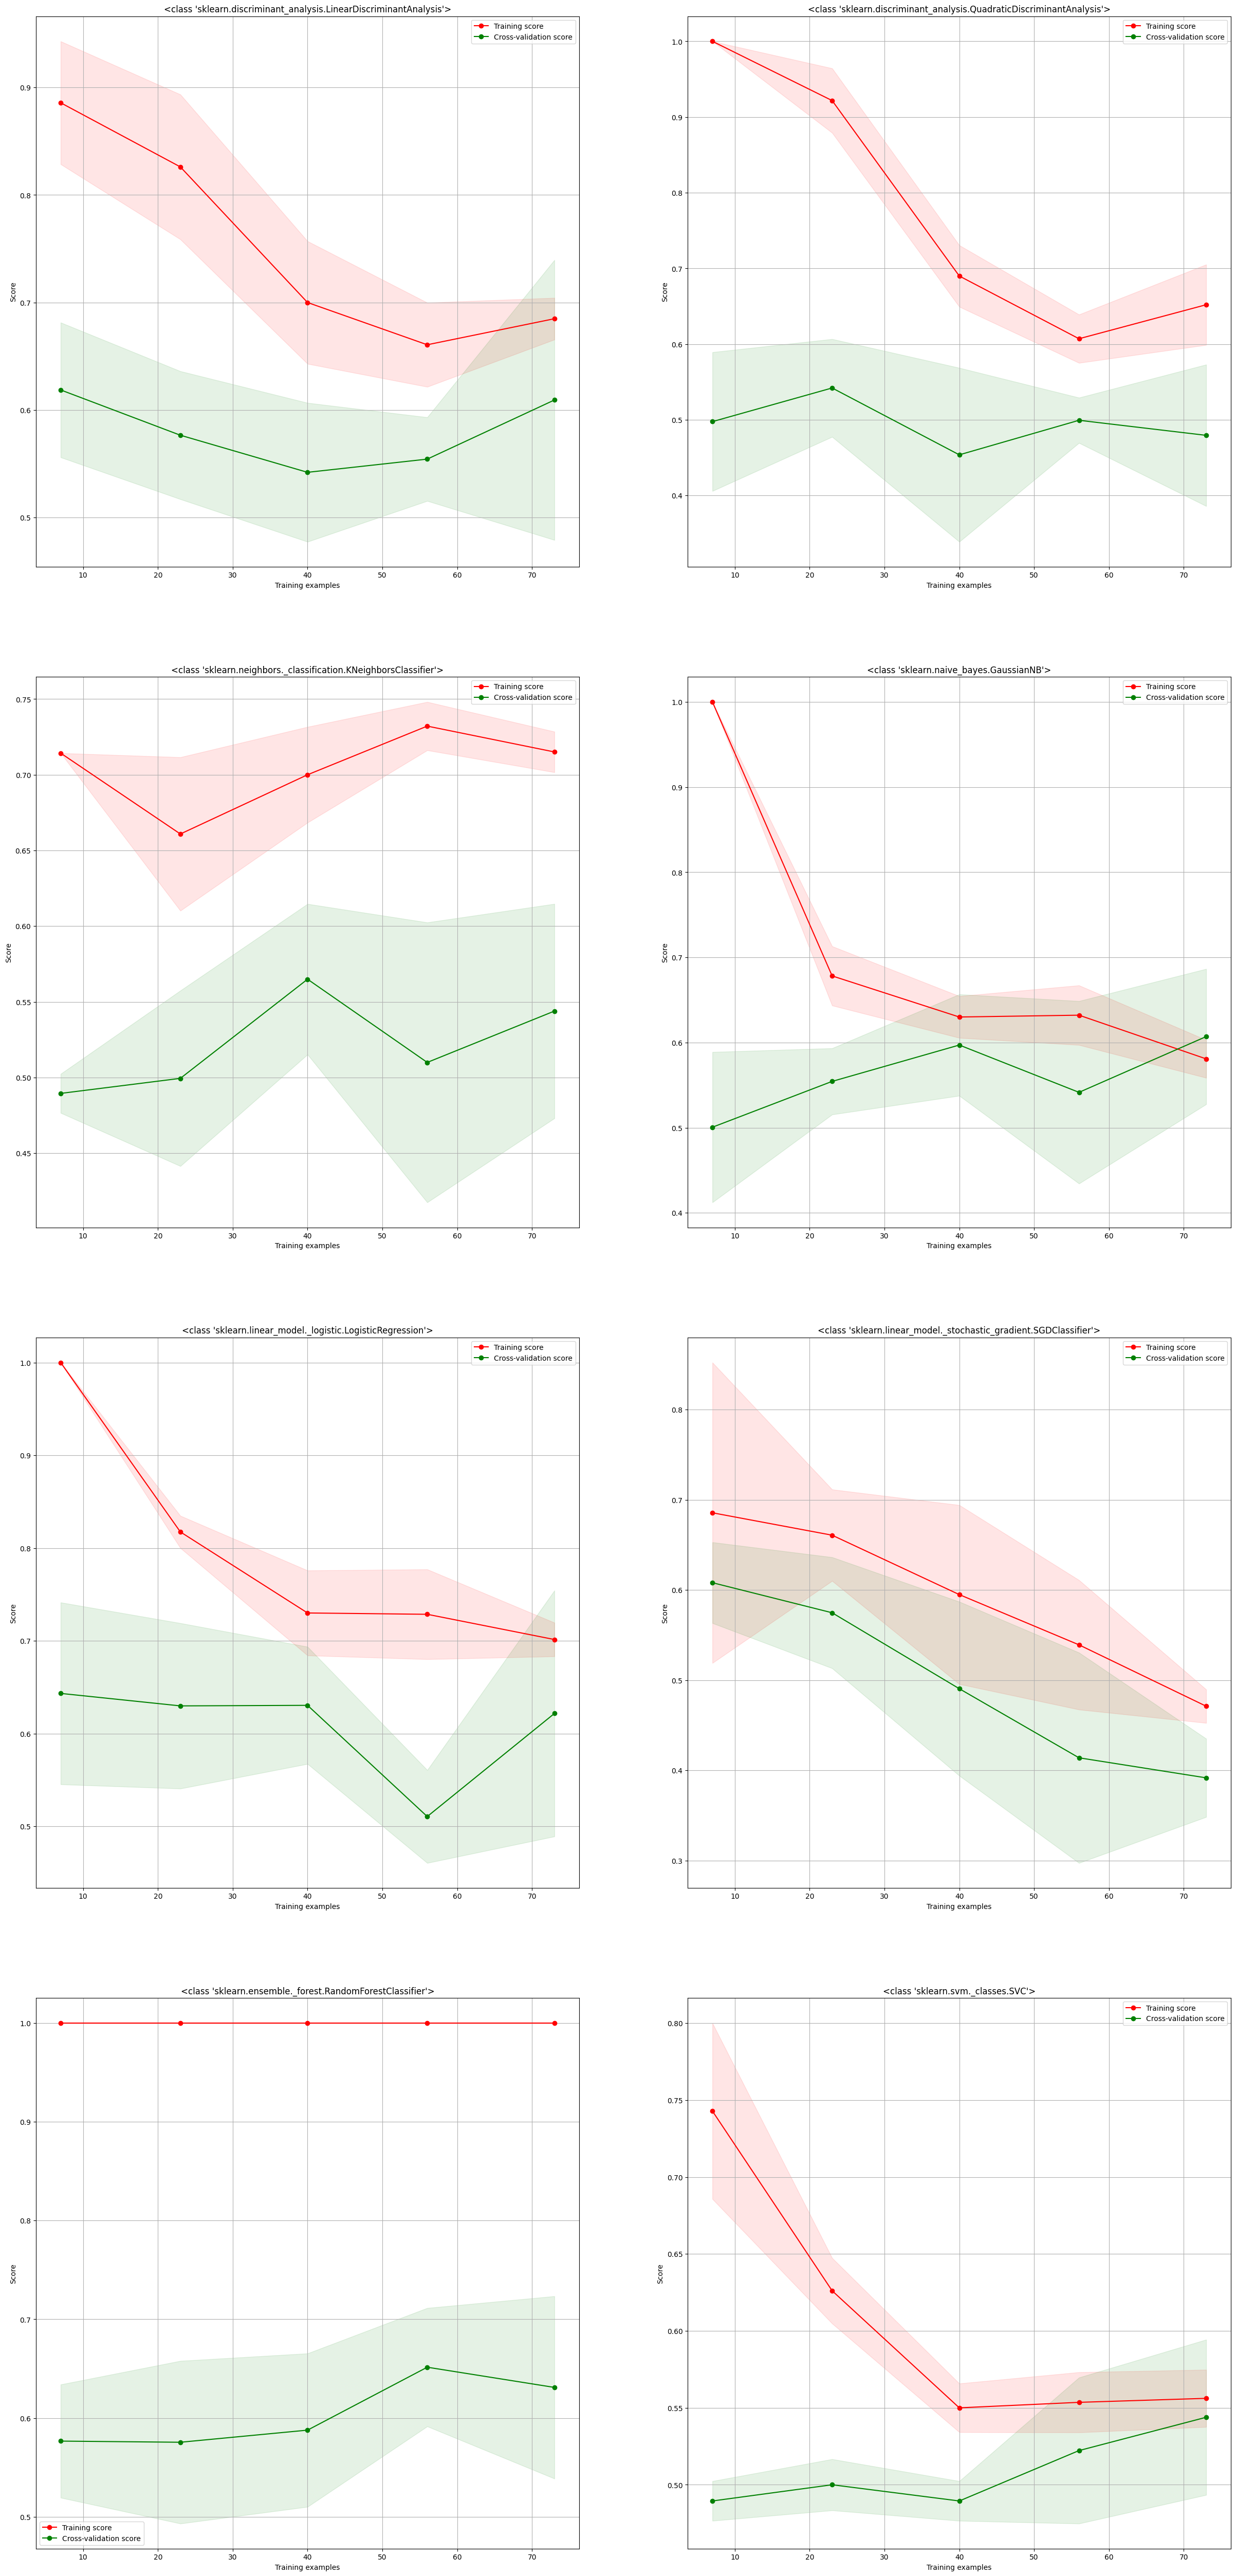

In [52]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, Xs, Ys, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, Xs, Ys, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

fig, axes = plt.subplots(4, 2, figsize=(30, 8*len(clsfs)))
axes = axes.flatten()  # make it a 1D array so you can index it easily

num = 0

for clf in clsfs:
    for X, Y in zip(Xs, Ys):
        title = str(type(clf))
        plot_learning_curve(clf, title, X, Y, axes[num])
        num += 1



#### Hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

#gaussian
param_grid_gnb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

grid_gnb = GridSearchCV(GaussianNB(), param_grid_gnb, cv=5, scoring='accuracy')
grid_gnb.fit(X_train, y_train)

print("Best parameters (GaussianNB):", grid_gnb.best_params_)
print("Best CV accuracy:", grid_gnb.best_score_)

#random forest 
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)

print("Best parameters (Random Forest):", grid_rf.best_params_)
print("Best CV accuracy:", grid_rf.best_score_)

# logistic regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],  # 'l1' requires solver='liblinear'
    'solver': ['lbfgs']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(X_train, y_train)

print("Best parameters (Logistic Regression):", grid_lr.best_params_)
print("Best CV accuracy:", grid_lr.best_score_)

# svm 
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_svc = GridSearchCV(SVC(), param_grid_svc, cv=5, scoring='accuracy')
grid_svc.fit(X_train, y_train)

print("Best parameters (SVM):", grid_svc.best_params_)
print("Best CV accuracy:", grid_svc.best_score_)




Best parameters (GaussianNB): {'var_smoothing': 1e-09}
Best CV accuracy: 0.6070175438596491
Best parameters (Random Forest): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best CV accuracy: 0.684795321637427


/Applications/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Best parameters (Logistic Regression): {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV accuracy: 0.5988304093567252
Best parameters (SVM): {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV accuracy: 0.5444444444444444


/Applications/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



GaussianNB Evaluation:
Accuracy: 0.6086956521739131
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.27      0.40        11
           1       0.58      0.92      0.71        12

    accuracy                           0.61        23
   macro avg       0.66      0.59      0.55        23
weighted avg       0.66      0.61      0.56        23

Confusion Matrix:
 [[ 3  8]
 [ 1 11]]

Random Forest Evaluation:
Accuracy: 0.6086956521739131
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.55      0.57        11
           1       0.62      0.67      0.64        12

    accuracy                           0.61        23
   macro avg       0.61      0.61      0.61        23
weighted avg       0.61      0.61      0.61        23

Confusion Matrix:
 [[6 5]
 [4 8]]

Logistic Regression Evaluation:
Accuracy: 0.6521739130434783
Classification Report:
               precision    reca

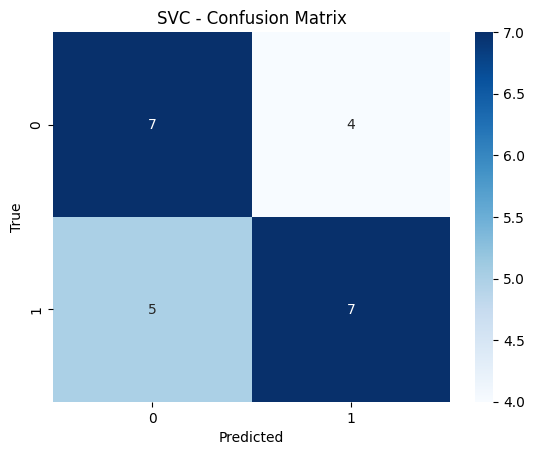

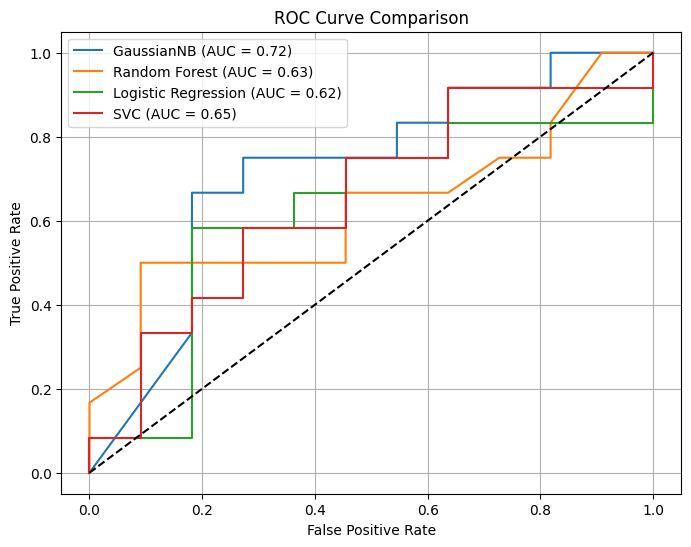

In [54]:
# Retraining models with the best parameters from GridSearch
best_gnb = GaussianNB(**grid_gnb.best_params_)
best_rf = RandomForestClassifier(**grid_rf.best_params_, random_state=42)
best_lr = LogisticRegression(**grid_lr.best_params_, max_iter=1000)
best_svc = SVC(**grid_svc.best_params_)

# Fit all best models on the full training data
best_gnb.fit(X_train, y_train)
best_rf.fit(X_train, y_train)
best_lr.fit(X_train, y_train)
best_svc.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

models = {
    "GaussianNB": best_gnb,
    "Random Forest": best_rf,
    "Logistic Regression": best_lr,
    "SVC": best_svc
}

for name, model in models.items():
    if name == "Random Forest":
        y_pred = model.predict(X_test)  # no scaling
    else:
        y_pred = model.predict(X_test)

    print(f"\n{name} Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt

model_name = "SVC"  # Change to "Logistic Regression", "Random Forest", etc.
model = models[model_name]

if model_name == "Random Forest":
    y_pred = model.predict(X_test)
else:
    y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title(f"{model_name} - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize y_test if not already binary (assumes 2 classes: 0 and 1)
# Only do this if y_test is not already 0/1
# y_test_bin = label_binarize(y_test, classes=[0, 1]).ravel()

# For simplicity, assume y_test is already binary (0/1)
plt.figure(figsize=(8, 6))

for name, model in models.items():
    if name == "Random Forest":
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        continue  # skip if scoring not available

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Diagonal line (random guess)
plt.plot([0, 1], [0, 1], 'k--')

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_accuracy(model, X_test, y_test, scaled=False, scaler=None):
    if scaled and scaler is not None:
        X_test = scaler.transform(X_test)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return accuracy

for name, model in models.items():
    scaled = False if name == "Random Forest" else True
    print(f"\n{name}:")
    evaluate_accuracy(model, X_test, y_test, scaled=scaled, scaler=scaler)




GaussianNB:
Accuracy: 52.17%

Random Forest:
Accuracy: 60.87%

Logistic Regression:
Accuracy: 73.91%

SVC:
Accuracy: 73.91%


/Applications/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Applications/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
